In [37]:

from glob import glob
from PIL import Image
from resizeimage import resizeimage
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import minmax_scale


#for VGG16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.layers import Dense, Input, Flatten, Dropout
from keras.models import Model
import tensorflow as tf

## Data Preprocessing

I am using a code snippet given for PCW 4.1 to import the data. I am also reducing a dataset size only to 1000 observations because my computer could not run the models on full data. I understand that it decreases accuracy. But i cannot run the model fully. I have combined both and women and reshuffled the images. Then, I have reduced the size of the dataset. Therefore, the removal of the images is random.  

In [21]:
size =  [200,200]
woman_images =  glob('Woman/*')
man_images =  glob('Man/*')



def data_transformation(images, size, gender):
    # create paths for all images
    # print(woman_images)

    flattened = []
    # for each image path
    for path in images:
        # open it as a read file in binary mode
        with open(path, 'r+b') as f:
            # open it as an image
            with Image.open(f) as image:
                
                
                #Check if the image is too small
                if min(image.size) < min(size):
                    
                    #If it is, enlarge to the img_size
                    cover = image.resize(size)
                    
                else:
                    # resize the image to be more manageable
                    cover = resizeimage.resize_cover(image, size)
                # flatten the matrix to an array and append it to all flattened images
                flattened.append((np.array(cover).flatten(), gender))
    #             print(cover)


    # Flatten it once more
    flattened = np.asarray(flattened)
    # print(woman_flattened)


    # Declare which are the X and Y inputs
    X_y= flattened
#     y_f = flattened[:,1]


    # X = np.delete(X, 500)
    # Y = np.delete(Y, 500)


#     # Use np.stack to put the data into the right dimension
#     X = np.stack(i for i in X_f)
#     y = np.stack(i for i in y_f)
    
    return X_y


X_y_man = data_transformation(man_images, size, 0)
X_y_woman = data_transformation(woman_images, size, 1)



X_y_combined = np.concatenate([X_y_man,X_y_woman])

np.random.default_rng().shuffle(X_y_combined)

print(X_y_combined.shape)

X_y_shortened = X_y_combined[:1000]

X= np.stack(i for i in X_y_combined[:, 0])

y= np.stack(i for i in X_y_combined[:, 1])

X_shortened= np.stack(i for i in X_y_shortened[:, 0])

y_shortened= np.stack(i for i in X_y_shortened[:, 1])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(2512, 2)


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


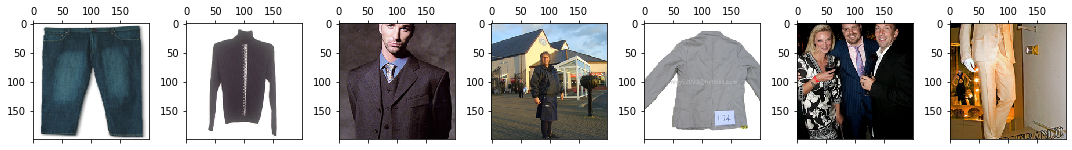

In [22]:
#source: https://stackoverflow.com/questions/52305259/matplotlib-10-x-10-matrix-only-populating-last-instance
plt.figure(figsize=(15,15))
for i,image in enumerate(np.random.choice(500,7)):
    plt.subplot(1,7,i+1).matshow(X_y_man[image,0].reshape((200,200,3)))
plt.tight_layout()
plt.show()

## Training and testing the data

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_shortened,y_shortened,test_size=0.20)

## SVM with Kernels 

I am adapting the code from the Assignment 4 and doing the grid search for each of the kernels and C. I have shortened the dataset to only 1000 observations of both female and male shirts that are chosen randomly, since my laptop took a really long time on a single kernel search for the full dataset. This most likely reduces the accuracy, but we can see, that the model is doing better than random. The DNN will perform better. 


Based on the different kernels, rbf and poly are approximately at the same accuracy rates of 65% on the testing data and are doing really good on the training data. All three kernels overfit. 

In [33]:
# X_train= X_train[:1000]
# y_train =y_train[:1000]


#create a list of all kernels to iterate over 
kernels = [dict(kernel='linear'), dict(kernel='rbf'), dict(kernel='poly', degree=2)]

#I am adapting the code from Assignment 4 in paramter grid search but iteration over the kernels
for kernel_ in kernels:
    
    #get the parameter for inidivudal kernel
    param_grid = dict(C =[0.1,1,10], **({key:[kernel_[key]] for key in kernel_}))
#     print(param_grid)
    grid_search = GridSearchCV(SVC(), param_grid= param_grid)
    grid_search.fit(X_shortened, y_shortened)
    best_params = grid_search.best_params_
    
    
    #fit the model
    clf = SVC(**best_params)
    clf.fit(X_train, y_train)


    #training accuracy
    y_train_pred = clf.predict(X_train)
    
    print('Accuracy for Training', kernel_['kernel'], ':', accuracy_score(y_train, y_train_pred), '\n')

    #testing accuracy
    y_pred = clf.predict(X_test)
    print('Accuracy for Testing', kernel_['kernel'], ':', accuracy_score(y_test, y_pred), '\n')



Accuracy for Training linear : 1.0 

Accuracy for Testing linear : 0.585 

Accuracy for Training rbf : 1.0 

Accuracy for Testing rbf : 0.655 

Accuracy for Training poly : 0.9725 

Accuracy for Testing poly : 0.645 



## Deep Neural Networks


The first layer of the model will be Flatten() to reshape the input data. Then, I will use the Dropout () function to prevent overfitting to randomly drop a certain portion of the connections. Finally, the output layer is the Sigmoid() layer because we are classifying images into male and female. 

The loss function is binary crossenthropy because we are classifying into two categories. 


In [56]:
#Adaptation from the Session 18 PCW.

# Generate a model with all layers (with top)
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(*size, 3))
# print(vgg16.summary())


#input format
input_ = vgg16.input

#Use the generated model 
output_vgg16_conv = vgg16(input_)


#Add a layer with 2 outputs 
#first layer so that the input size matches for the labels
#source: https://github.com/keras-team/keras/issues/4465
x = Flatten(name='flatten')(output_vgg16_conv)

x = Dropout(rate = 0.3)(x)
#output layer
x = Dense(1, activation='sigmoid', name='predictions')(x)

#Then create the corresponding model 
my_model = Model(inputs=vgg16.input, outputs=x)
for layer in my_model.layers[:len(my_model.layers)-1]:
    layer.trainable = False

#loss is categorcial crossenthropy because clases are not numerical
my_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
my_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout_6 (Dropout)         (None, 25088)             0         
                                                                 
 predictions (Dense)         (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [57]:
#getting the data for the shirts
data_train = tf.keras.preprocessing.image_dataset_from_directory(r"/Users/milanastetsenko/Desktop/Junior Year/CS156/train_directory",
                                                                  labels = 'inferred',
                                                                  image_size=size,
                                                                  shuffle=True,
                                                                  label_mode ='binary'
                                                                  )
#getting the data for the shirts
data_test = tf.keras.preprocessing.image_dataset_from_directory(r"/Users/milanastetsenko/Desktop/Junior Year/CS156/test_directory",
                                                                  labels = 'inferred',
                                                                  image_size=size,
                                                                  shuffle=True,
                                                                  label_mode ='binary'
                                                                  )
#sanity check
print(data_train.class_names)

Found 1866 files belonging to 2 classes.
Found 52 files belonging to 2 classes.
['Man', 'Woman']


In [41]:
#alternating the data to avoid errors
#source: https://stackoverflow.com/questions/49161174/tensorflow-logits-and-labels-must-have-the-same-first-dimension
data_train = data_train.cache()
data_train = data_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [42]:
#sanity check for the input sizes
for image_batch, labels_batch in data_train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 200, 200, 3)
(32, 1)


In [62]:
history = my_model.fit(
    data_train, validation_data=data_test, 
    epochs = 4)

Epoch 1/4
59/59 [==============================] - 315s 5s/step - loss: 1.3561 - accuracy: 0.9164 - val_loss: 2.6441 - val_accuracy: 0.8846
Epoch 2/4
59/59 [==============================] - 297s 5s/step - loss: 0.5916 - accuracy: 0.9539 - val_loss: 3.8111 - val_accuracy: 0.8462
Epoch 3/4
59/59 [==============================] - 333s 6s/step - loss: 0.3742 - accuracy: 0.9695 - val_loss: 2.7036 - val_accuracy: 0.8077
Epoch 4/4
59/59 [==============================] - 269s 5s/step - loss: 0.2432 - accuracy: 0.9764 - val_loss: 2.9340 - val_accuracy: 0.8846


## Summary


The VGG16 model does a much better job at classifying images than any of the Kernels in SVM. DNN was already pre-trained and won the competition, so it comes at no suprise. More than that, DNN has much more parameters It has an accuracy on the testing data of 88% as opposed to 65% of SVM.  